In [1]:
!pip install matplotlib==3.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 59.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


In [2]:
!pip install torchview

In [4]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.6 MB/s eta 0:00:00


In [18]:
!pip install torchinfo

In [5]:
import os, sys, itertools, glob, torch, torchvision, cv2, natsort
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from numpy import asarray
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from PIL import Image
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, Dataset
import torchvision.transforms as transforms
torch.manual_seed(46)
from torch import nn
import torchvision
from torchview import draw_graph
import torch.nn.functional as F
from captum.attr import visualization as viz
from captum.attr import IntegratedGradients, LayerGradCam, LayerAttribution, NoiseTunnel, GuidedGradCam

In [6]:
print('Folders inside the main directory: ', os.listdir("/content/drive/MyDrive/gaf_imgs"))

Folders inside the main directory:  ['label_0', 'label_1']


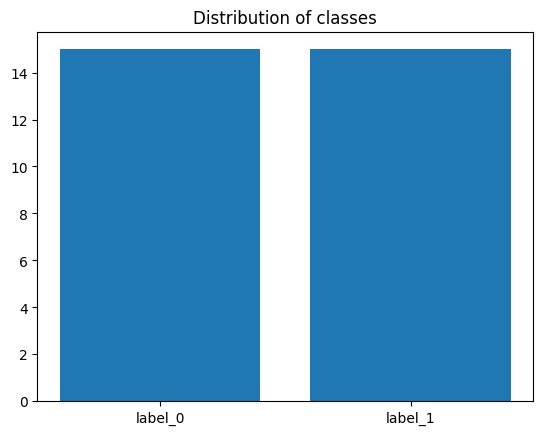

In [9]:
classes = ['label_0', 'label_1']
sum_images = []
for i in classes:
    img_base_path = "/content/drive/MyDrive/gaf_imgs/" + str(i)
    images = os.listdir(img_base_path)
    sum_images.append(len(images))
plt.bar(classes, sum_images)
plt.title('Distribution of classes')
plt.show()

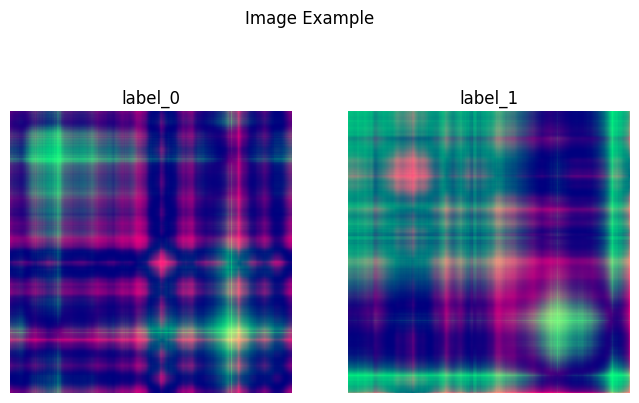

In [11]:
images = []
paths = []

fig,ax = plt.subplots(1,2,figsize = (8,5))
ax = ax.ravel()

for idx, i in enumerate(classes):
    img_base_path = "/content/drive/MyDrive/gaf_imgs/" + str(i) #link of the subfolders
    timages = os.listdir(img_base_path) #list of images inside each subfolders
    images_path_to_display = os.path.join(img_base_path, str(timages[0]))
    paths.append(images_path_to_display)
    img = Image.open(images_path_to_display)
    images.append(img)
    image = images[idx]
    ax[idx].axis('off')
    ax[idx].imshow(image,cmap = 'gray')
    ax[idx].set_title(str(i))

plt.suptitle('Image Example')
plt.show()

In [12]:
data = datasets.ImageFolder('/content/drive/MyDrive/gaf_imgs')
transform = transforms.Compose([transforms.RandomHorizontalFlip(1),
                                transforms.RandomVerticalFlip(1),
                                transforms.RandomRotation(30),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])])
class loadData(Dataset):
    def __init__(self, dataset, transform = None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        if self.transform:
            x = self.transform(self.dataset[index][0])

        y = self.dataset[index][1]
        return x, y

    def __len__(self):
        return len(self.dataset)
dataset = loadData(data, transform)
print(dataset[0][0].shape)

torch.Size([3, 250, 250])


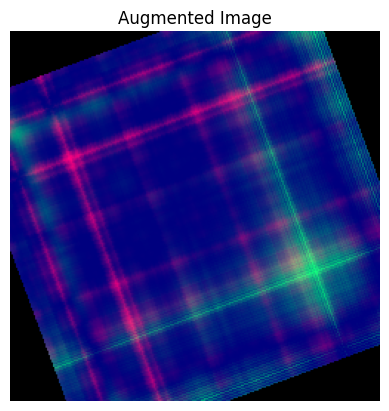

In [13]:
plt.imshow(dataset[3][0].permute(1, 2, 0))
plt.axis('off')
plt.title('Augmented Image')
plt.show()

In [14]:
class SeqCNN(nn.Module):

  # Constructor
  def __init__(self):
    # Call parent contructor
    super().__init__()
    self.conv_layer = nn.Sequential(
        # Layer 1
        nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, padding=2, stride=1, dilation=1, padding_mode='zeros'),
        nn.BatchNorm2d(8), # Add Batch Normalization
        nn.ReLU(),
        # Layer 2
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=1, dilation=1, padding_mode='zeros'),
        nn.BatchNorm2d(16), # Add Batch Normalization
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # Layer 3
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1, dilation=1, padding_mode='zeros'),
        nn.BatchNorm2d(32), # Add Batch Normalization
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )

  # Forward
  def forward(self, x):
    x = self.conv_layer(x)
    return x

In [15]:
net = SeqCNN()

img = dataset[0][0]
img = img.unsqueeze(0)

output = net(img)
print(output.shape)


out_features = output.size(1) * output.size(2) * output.size(3)
print(out_features)

torch.Size([1, 32, 62, 62])
123008


In [16]:
class CNN(nn.Module):

 # Constructor
  def __init__(self):
    # Call parent contructor
    super().__init__()
    self.conv_layer = nn.Sequential(
        # Layer 1
        nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, padding=2, stride=1, dilation=1, padding_mode='zeros'),
        nn.BatchNorm2d(8), # Add Batch Normalization
        nn.ReLU(),
        # Layer 2
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=1, dilation=1, padding_mode='zeros'),
        nn.BatchNorm2d(16), # Add Batch Normalization
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # Layer 3
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1, dilation=1, padding_mode='zeros'),
        nn.BatchNorm2d(32), # Add Batch Normalization
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )

    # Create fully-connected layers
    self.fc_layers = nn.Sequential(
        # a first FC layer
        nn.Linear(123008, 1012), #input and output neurons
        nn.ReLU(),
        # the final Classification Layer
        nn.Linear(1012, 2)  #input and output neurons
    )

  # Forward
  def forward(self, x):
    x = self.conv_layer(x)     # x has size [batch_size, num_filters, height, width] before passing to fc layer, we have to flatten x
    x = x.view(x.size(0), -1)  # now x has size [batch_size, num_features]
    output = self.fc_layers(x) #  --> [B, 10]
    return output

In [33]:
import torchinfo
model = CNN()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
torchinfo.summary(model, (3, 250, 250), batch_dim = 0, col_names = ('input_size', 'output_size', 'num_params'), verbose = 0)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
CNN                                      [1, 3, 250, 250]          [1, 2]                    --
├─Sequential: 1-1                        [1, 3, 250, 250]          [1, 32, 62, 62]           --
│    └─Conv2d: 2-1                       [1, 3, 250, 250]          [1, 8, 250, 250]          608
│    └─BatchNorm2d: 2-2                  [1, 8, 250, 250]          [1, 8, 250, 250]          16
│    └─ReLU: 2-3                         [1, 8, 250, 250]          [1, 8, 250, 250]          --
│    └─Conv2d: 2-4                       [1, 8, 250, 250]          [1, 16, 250, 250]         1,168
│    └─BatchNorm2d: 2-5                  [1, 16, 250, 250]         [1, 16, 250, 250]         32
│    └─ReLU: 2-6                         [1, 16, 250, 250]         [1, 16, 250, 250]         --
│    └─MaxPool2d: 2-7                    [1, 16, 250, 250]         [1, 16, 125, 125]         --
│    └─Conv2d: 2-8             

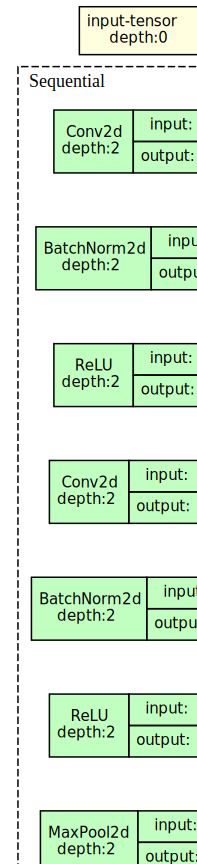

In [20]:
model_graph = draw_graph(model, input_size=(1,3,250,250), roll=True, expand_nested=True, directory='')
model_graph.visual_graph

In [31]:
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr = 0.0001)
# Define a loss
criterion = nn.CrossEntropyLoss()

In [32]:
from sklearn.model_selection import KFold
from torch.utils.data import Dataset, DataLoader, TensorDataset, SubsetRandomSampler, ConcatDataset

num_epochs=30
batch_size=1
k=5
splits=KFold(n_splits=k,shuffle=True,random_state=42)
foldperf={}

In [29]:
def train_epoch(model,device,dataloader,loss_fn,optimizer):
    train_loss,train_correct=0.0,0
    model.train()
    for images, labels in dataloader:

        images,labels = images.to(device),labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()

    return train_loss,train_correct

def valid_epoch(model,device,dataloader,loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    with torch.no_grad():
      for images, labels in dataloader:

          images,labels = images.to(device),labels.to(device)
          output = model(images)
          loss=loss_fn(output,labels)
          valid_loss+=loss.item()*images.size(0)
          scores, predictions = torch.max(output.data,1)
          val_correct+=(predictions == labels).sum().item()

    return valid_loss,val_correct

In [34]:
history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):

    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

    model = CNN()
    model.to(device)

    for epoch in range(num_epochs):
        train_loss, train_correct=train_epoch(model,device,train_loader,criterion,optimizer)
        test_loss, test_correct=valid_epoch(model,device,test_loader,criterion)

        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        test_loss = test_loss / len(test_loader.sampler)
        test_acc = test_correct / len(test_loader.sampler) * 100

        print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1,
                                                                                                             num_epochs,
                                                                                                             train_loss,
                                                                                                             test_loss,
                                                                                                             train_acc,
                                                                                                             test_acc))
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

Fold 1
Epoch:1/30 AVG Training Loss:0.699 AVG Test Loss:0.674 AVG Training Acc 50.00 % AVG Test Acc 66.67 %
Epoch:2/30 AVG Training Loss:0.707 AVG Test Loss:0.702 AVG Training Acc 41.67 % AVG Test Acc 83.33 %
Epoch:3/30 AVG Training Loss:0.684 AVG Test Loss:0.655 AVG Training Acc 45.83 % AVG Test Acc 66.67 %
Epoch:4/30 AVG Training Loss:0.701 AVG Test Loss:0.625 AVG Training Acc 37.50 % AVG Test Acc 66.67 %
Epoch:5/30 AVG Training Loss:0.684 AVG Test Loss:0.672 AVG Training Acc 54.17 % AVG Test Acc 66.67 %
Epoch:6/30 AVG Training Loss:0.694 AVG Test Loss:0.645 AVG Training Acc 50.00 % AVG Test Acc 66.67 %
Epoch:7/30 AVG Training Loss:0.668 AVG Test Loss:0.764 AVG Training Acc 54.17 % AVG Test Acc 50.00 %
Epoch:8/30 AVG Training Loss:0.707 AVG Test Loss:0.683 AVG Training Acc 50.00 % AVG Test Acc 66.67 %
Epoch:9/30 AVG Training Loss:0.706 AVG Test Loss:0.701 AVG Training Acc 37.50 % AVG Test Acc 66.67 %
Epoch:10/30 AVG Training Loss:0.657 AVG Test Loss:0.670 AVG Training Acc 66.67 % AVG

In [35]:
avg_train_loss = np.mean(history['train_loss'])
avg_test_loss = np.mean(history['test_loss'])
avg_train_acc = np.mean(history['train_acc'])
avg_test_acc = np.mean(history['test_acc'])

print('Performance of {} fold cross validation'.format(k))
print("Average Training Loss: {:.4f} \t Average Test Loss: {:.4f} \t Average Training Acc: {:.3f} \t Average Test Acc: {:.3f}".format(avg_train_loss,avg_test_loss,avg_train_acc,avg_test_acc))

Performance of 5 fold cross validation
Average Training Loss: 0.7058 	 Average Test Loss: 0.6767 	 Average Training Acc: 47.583 	 Average Test Acc: 61.778


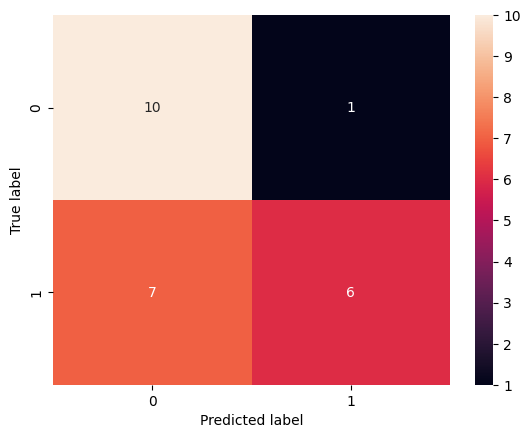

In [47]:
import seaborn as sns
confusion_matrix = np.zeros((2, 2))
with torch.no_grad():
    for i, (inputs, classes) in enumerate(train_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

plt.figure()
df_cm = pd.DataFrame(confusion_matrix).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Interpretability

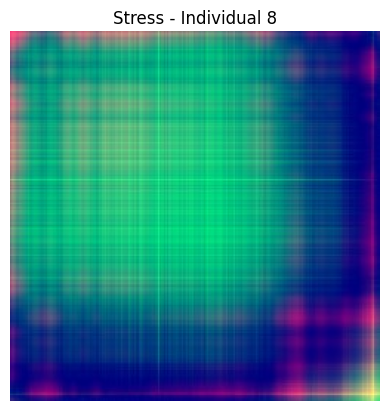

In [72]:
test_img = Image.open('/content/img_6.jpeg')
test_img_data = np.asarray(test_img)
plt.imshow(test_img_data)
plt.title('Stress - Individual 8')
plt.axis('off')
plt.show()

In [75]:
test_transform = transforms.Compose([
 transforms.ToTensor()])

transform_normalize = transforms.Normalize(
     mean=[0, 0, 0],
     std=[1, 1, 1])

transformed_img = test_transform(test_img)
norm_img = transform_normalize(transformed_img)
input_img = norm_img.unsqueeze(0)
input_img = input_img.to(device)
output = model(input_img)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)
pred_label_idx.squeeze_()

tensor(0, device='cuda:0')

/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/captum/attr/_utils/visualization.py:51: UserWarning: Attempting to normalize by value approximately 0, visualized resultsmay be misleading. This likely means that attribution values are allclose to 0.
  warnings.warn(


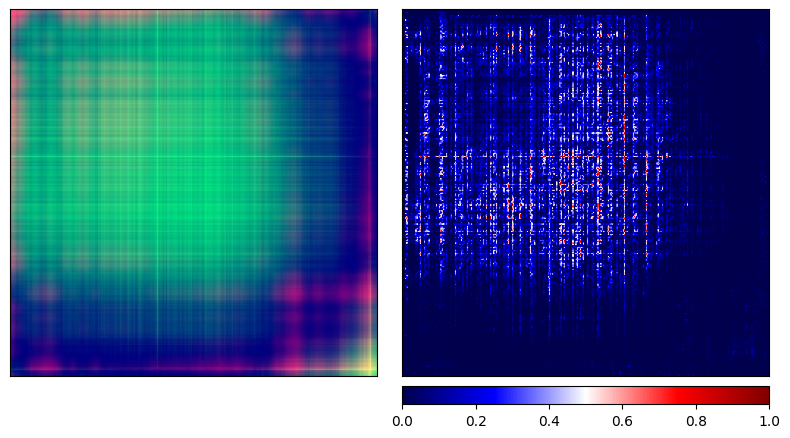

In [74]:
gg = GuidedGradCam(model, model.conv_layer[7])
gg_attr = gg.attribute(input_img, pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(gg_attr.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(input_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ['original_image', "heat_map"],
                                      ["all", "positive"],
                                      cmap=cm.seismic,
                                      show_colorbar=True)